In [1]:
import torch
import sys
sys.path.append("/home/onyxia/work/Advanced-ML")
from data_loader import S3ParquetReader
from config import USER
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from models import AutoEncoder, train_model, CombinedLoss
from torch.optim import Adam

## Data Loading

Config initialisation

In [2]:
BUCKET = f"/{USER}/jane_street_data"
reader = S3ParquetReader(bucket=BUCKET)
FILE_KEY_S3 = "preprocessed.parquet/data_clean_symb_1.parquet"

In [3]:
data = reader.read_parquet(FILE_KEY_S3)
data.head()

date_id,time_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_08,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_28,feature_29,feature_30,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_43,feature_44,feature_45,feature_46,…,feature_52,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,feature_time_sin,feature_time_cos
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64
0,35,1,3.889038,0.127298,0.339121,-0.045494,0.151473,-0.038995,-0.644192,-0.193971,-0.016662,-0.213108,-0.045016,0.014899,0.128033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.397016,0.694868,0.812098,-0.128621,0.025559,0.018694,-0.006306,-1.706433,-0.490941,0.425017,0.281025,-0.134582,0.046605,…,-0.207253,-0.307967,0.381731,0.756464,0.058235,0.060041,-0.479444,-0.000608,0.0,-0.000122,0.085259,-0.324355,-0.097414,-0.296044,0.21344,-0.20025,-0.11987,-0.007101,-0.693186,-0.181427,0.073886,-0.062266,0.136151,0.110356,0.055748,-0.028266,0.36224,-0.376568,-0.086291,-0.392552,-0.267725,-0.112329,-1.233082,0.131704,-0.024239,0.225461,0.974252
0,36,1,3.889038,0.114208,-1.419921,-0.505525,-0.258195,0.017889,-0.254385,0.015691,-0.020583,-0.15111,-0.034961,-0.045215,-0.411787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.037745,-0.824408,-0.312367,0.272155,0.041673,0.051002,0.101001,-0.172871,0.356697,0.43781,-0.243426,0.116691,0.21925,…,0.174336,-0.325709,-0.301785,-0.332396,0.651199,-0.103911,-0.210683,0.088785,0.0,-0.013245,-0.067586,0.22172,0.347892,0.511532,-0.214167,-0.045423,-0.048534,0.048807,-0.407794,0.008081,-0.071584,0.056597,0.01653,-0.049644,-0.023103,-0.0531,0.283566,-0.397785,0.041572,0.001317,-0.112683,0.419467,-0.578848,0.269364,0.459819,0.231787,0.972767
0,37,1,3.889038,0.118826,-1.293755,-0.809856,0.268584,-0.056675,-0.273341,-0.016404,0.010669,0.172457,0.011381,0.013246,-0.016248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571682,0.168574,-0.042331,-0.55658,0.175519,-0.052067,0.053939,0.109843,-0.055707,-0.214608,-0.026042,-0.180718,-0.171372,…,-1.097941,-0.294437,-0.104787,0.504722,-0.285762,0.140226,-0.521822,-0.46183,0.0,0.226184,-0.100162,-0.029472,0.037072,0.097566,0.061552,-0.136708,-0.029742,-0.047774,-0.150518,-0.287006,-0.000054,-0.048201,-0.093462,-0.015866,0.051347,0.055587,0.260547,-0.299865,0.239627,-0.019651,-0.194262,0.321798,-0.683034,0.027111,0.075722,0.238102,0.97124
0,38,1,3.889038,-0.216346,-0.021069,-0.425764,-0.005701,-0.010654,0.302838,0.000491,-0.017648,-0.036415,-0.008958,0.384812,0.49453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.202302,0.395804,-0.512155,0.642004,0.414221,0.113961,-0.131998,-0.374575,0.206433,-0.445924,-0.518108,0.268771,0.069906,…,0.08609,-0.610097,0.137679,-0.198983,-0.754921,-0.294851,0.352242,0.049567,0.0,-0.023089,0.036929,-0.176699,-0.503255,-0.449954,-0.134894,0.050516,-0.089379,0.004014,-0.204778,-0.144482,-0.082102,-0.050271,0.020269,-0.008658,0.096835,-0.042524,0.423799,-0.195033,0.145029,-0.076218,-0.304814,0.098249,-0.606483,-0.01076,-0.134628,0.244408,0.969673
0,39,1,3.889038,-0.660073,2.168059,0.903407,-0.101644,0.133174,-0.212203,-0.217244,0.006182,-0.076704,-0.027879,0.249095,-0.431726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.511043,-0.221639,-0.014473,-0.572408,-0.297749,-0.126506,-0.083542,0.180433,-0.245343,0.052368,0.051568,-0.067317,0.585641,…,0.422847,1.033209,-0.497286,-0.080836,0.111428,0.3511

Define features and target

In [4]:
target = "responder_6"
features = [col for col in data.columns if "feature" in col]

X, y = data[features], data[target]

Split data

In [5]:
n = X.height
n_train = int(0.8 * n)
X_train = X.slice(0, n_train)
y_train = y.slice(0, n_train)

X_val = X.slice(n_train)
y_val = y.slice(n_train)

Data Wraper

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        y = torch.tensor(y.to_numpy(), dtype=torch.float32)
        if y.ndim == 1:
            y = y.view(-1, 1)
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [8]:
train_data_loader = DataLoader(
    train_dataset, batch_size=2048, shuffle=False, num_workers=8
)
val_data_loader = DataLoader(val_dataset, batch_size=2048, shuffle=False, num_workers=8)

## Model Evaluation

Model hyperameters

In [9]:
n_feat = len(features)
n_latent = 16
encoder_hidden = [64, 32, 32]
decoder_hidden = [32, 64]
head_hidden = [8, 8, 4]

In [10]:
model = AutoEncoder(
    n_feat=n_feat,
    n_latent=n_latent,
    encoder_hidden=encoder_hidden,
    decoder_hidden=decoder_hidden,
    head_hidden=head_hidden,
)

Training hyperparameters

In [11]:
lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 1.0
beta = 0

In [12]:
optimizer = Adam(model.parameters(), lr=lr)
criterion = CombinedLoss(alpha=alpha, beta=beta)
n_epochs = 20

  5%|▌         | 1/20 [00:08<02:40,  8.45s/it]

Epoch 01 | loss=56.317 | R2_rec_train=-0.7371 | R2_rec_val=0.1444 | R2_sup_train=-0.5089 | R2_sup_val=-0.4381


 10%|█         | 2/20 [00:16<02:24,  8.04s/it]

Epoch 02 | loss=46.578 | R2_rec_train=-0.4909 | R2_rec_val=0.0432 | R2_sup_train=-0.5101 | R2_sup_val=-0.4494


 15%|█▌        | 3/20 [00:24<02:15,  7.98s/it]

Epoch 03 | loss=39.536 | R2_rec_train=0.1515 | R2_rec_val=-0.3216 | R2_sup_train=-0.5112 | R2_sup_val=-0.4510


 20%|██        | 4/20 [00:32<02:07,  8.00s/it]

Epoch 04 | loss=40.699 | R2_rec_train=0.0341 | R2_rec_val=0.0388 | R2_sup_train=-0.5185 | R2_sup_val=-0.4548


 25%|██▌       | 5/20 [00:40<02:02,  8.14s/it]

Epoch 05 | loss=38.037 | R2_rec_train=-0.0982 | R2_rec_val=-0.7715 | R2_sup_train=-0.5236 | R2_sup_val=-0.4522


 30%|███       | 6/20 [00:48<01:53,  8.09s/it]

Epoch 06 | loss=34.685 | R2_rec_train=0.2124 | R2_rec_val=0.2533 | R2_sup_train=-0.5207 | R2_sup_val=-0.4485


 35%|███▌      | 7/20 [00:56<01:44,  8.02s/it]

Epoch 07 | loss=32.815 | R2_rec_train=0.1784 | R2_rec_val=0.2191 | R2_sup_train=-0.5183 | R2_sup_val=-0.4498


 40%|████      | 8/20 [01:02<01:30,  7.53s/it]

Epoch 08 | loss=32.973 | R2_rec_train=0.2368 | R2_rec_val=0.1286 | R2_sup_train=-0.5163 | R2_sup_val=-0.4470


 45%|████▌     | 9/20 [01:10<01:21,  7.45s/it]

Epoch 09 | loss=34.526 | R2_rec_train=0.1106 | R2_rec_val=0.1502 | R2_sup_train=-0.5186 | R2_sup_val=-0.4517


 50%|█████     | 10/20 [01:18<01:15,  7.58s/it]

Epoch 10 | loss=35.068 | R2_rec_train=0.2256 | R2_rec_val=0.0608 | R2_sup_train=-0.5222 | R2_sup_val=-0.4571


 55%|█████▌    | 11/20 [01:24<01:05,  7.24s/it]

Epoch 11 | loss=33.981 | R2_rec_train=-0.0180 | R2_rec_val=-0.4010 | R2_sup_train=-0.5240 | R2_sup_val=-0.4549


 60%|██████    | 12/20 [01:30<00:55,  6.98s/it]

Epoch 12 | loss=31.830 | R2_rec_train=0.2115 | R2_rec_val=0.2338 | R2_sup_train=-0.5221 | R2_sup_val=-0.4541


 65%|██████▌   | 13/20 [01:38<00:49,  7.09s/it]

Epoch 13 | loss=30.903 | R2_rec_train=0.2709 | R2_rec_val=0.2197 | R2_sup_train=-0.5189 | R2_sup_val=-0.4466


 70%|███████   | 14/20 [01:45<00:42,  7.08s/it]

Epoch 14 | loss=30.894 | R2_rec_train=0.2253 | R2_rec_val=0.1569 | R2_sup_train=-0.5168 | R2_sup_val=-0.4472


 75%|███████▌  | 15/20 [01:52<00:35,  7.12s/it]

Epoch 15 | loss=30.729 | R2_rec_train=0.2244 | R2_rec_val=0.2323 | R2_sup_train=-0.5150 | R2_sup_val=-0.4458


 80%|████████  | 16/20 [02:00<00:28,  7.24s/it]

Epoch 16 | loss=31.443 | R2_rec_train=0.2438 | R2_rec_val=0.2685 | R2_sup_train=-0.5134 | R2_sup_val=-0.4453


 85%|████████▌ | 17/20 [02:06<00:21,  7.15s/it]

Epoch 17 | loss=30.943 | R2_rec_train=0.1265 | R2_rec_val=0.2186 | R2_sup_train=-0.5138 | R2_sup_val=-0.4458


 90%|█████████ | 18/20 [02:13<00:14,  7.05s/it]

Epoch 18 | loss=30.125 | R2_rec_train=-0.0190 | R2_rec_val=0.2792 | R2_sup_train=-0.5121 | R2_sup_val=-0.4453


 95%|█████████▌| 19/20 [02:21<00:07,  7.14s/it]

Epoch 19 | loss=31.350 | R2_rec_train=0.2418 | R2_rec_val=0.2076 | R2_sup_train=-0.5145 | R2_sup_val=-0.4429


100%|██████████| 20/20 [02:27<00:00,  7.40s/it]

Epoch 20 | loss=30.255 | R2_rec_train=0.2128 | R2_rec_val=0.2749 | R2_sup_train=-0.5140 | R2_sup_val=-0.4439


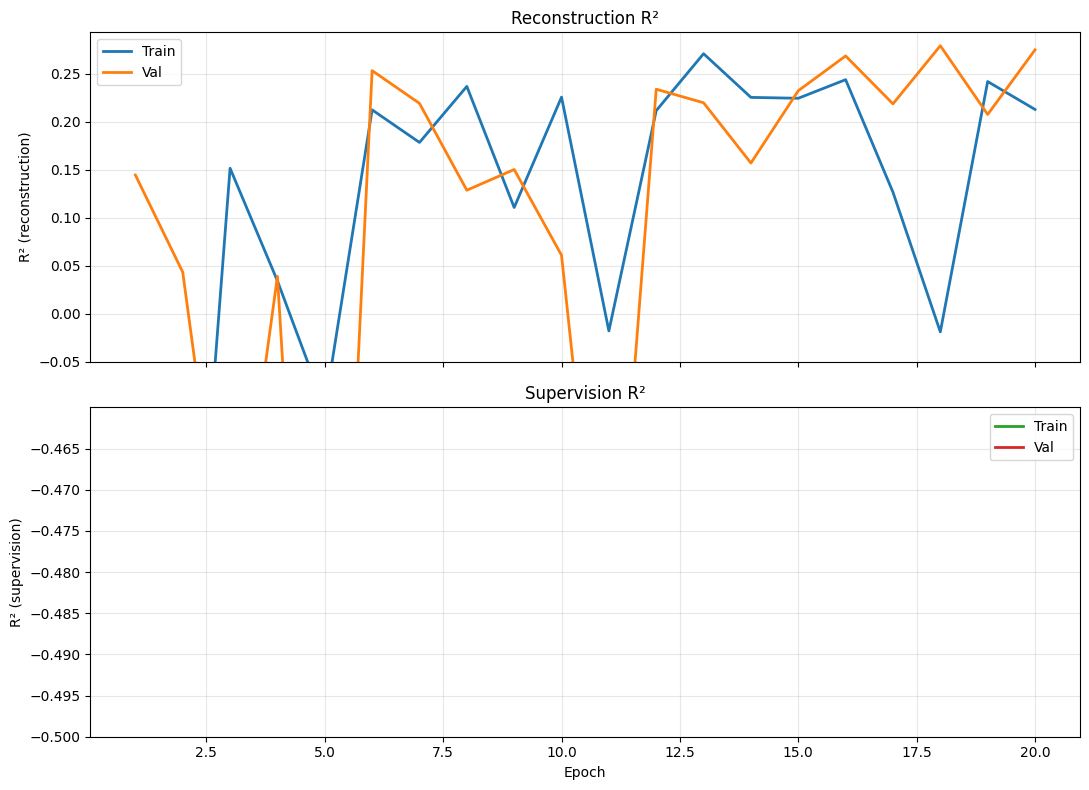

([-0.7371340990066528,
  -0.49089011549949646,
  0.15149058401584625,
  0.03414560481905937,
  -0.09818095713853836,
  0.2123560607433319,
  0.17839549481868744,
  0.2368042767047882,
  0.1105973944067955,
  0.22562409937381744,
  -0.018015408888459206,
  0.21153604984283447,
  0.27085989713668823,
  0.22533415257930756,
  0.2244243323802948,
  0.24379897117614746,
  0.126533642411232,
  -0.019024094566702843,
  0.24184897541999817,
  0.21278385818004608],
 [0.1444208323955536,
  0.04322982206940651,
  -0.32156237959861755,
  0.03881996124982834,
  -0.7715164422988892,
  0.25325876474380493,
  0.21909190714359283,
  0.12859322130680084,
  0.15019699931144714,
  0.06083203852176666,
  -0.401039719581604,
  0.23384229838848114,
  0.21973803639411926,
  0.15693172812461853,
  0.2322869896888733,
  0.26854607462882996,
  0.21860526502132416,
  0.27917829155921936,
  0.20756325125694275,
  0.27486053109169006],
 [-0.5089352130889893,
  -0.5100595951080322,
  -0.5112099647521973,
  -0.518501

In [13]:
train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    n_epochs=n_epochs,
)